Preliminary Testing on using pretrained EfficientNet models with the PyTorch finetuning tutorial for Torchvision models: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
import torchvision.models as models

In [ ]:
# has random weights by default
# for pre-trained instance pass in pretrained=true (weights stored in seperate directory that can be explicitly stated)
# pre-trained on 1000 ImageNet
efficientnet_b0 = models.efficientnet_b0()

In [ ]:
# train() and eval()
# ALL pretrained models expect mini-batches of 3 channel RGB images of shape (3 x H x W), w/ H and W expected to be at least 224
# images shouldbe loaded into range of [0,1], normalized using mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

In [ ]:
# https://glassboxmedicine.com/2020/12/08/using-predefined-and-pretrained-cnns-in-pytorch-tutorial-with-code/
# References this paper:https://openaccess.thecvf.com/content_ICCV_2019/papers/He_Rethinking_ImageNet_Pre-Training_ICCV_2019_paper.pdf
# May be better to 


In [ ]:
# see the interior structure
# efficientnet_b0

In [ ]:
# https://glassboxmedicine.com/2020/12/08/using-predefined-and-pretrained-cnns-in-pytorch-tutorial-with-code/
# can chop of parts of the model we don't want to use but keep everything else 
# common to cut off fully connected layers used for classification, then tack on our own 
# fully connected layers with right number of ouptuts for whatever we're solving

# drop the FC (fully connected) classifier at the end
import torch.nn as nn
features = nn.Sequential(*(list(efficientnet_b0.children())[0:-1]))

In [ ]:
# Show all remaining parts of the network
# features

In [ ]:
# ALTERNATIVE method 
model = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/hymenoptera_data/

train  val


In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "drive/MyDrive/hymenoptera_data/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    # save the weights in statedict
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# initialize our model
import torch.nn as nn
model_ft = models.efficientnet_b0(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extracting=True) # don't update gradients for the other layers
num_ftrs = model_ft.classifier[1].in_features # should be 1280
model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes) # numclasses defined earlier

# input size for efficientnet_b0 is 224 according to: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
input_size = 224


In [ ]:
model_ft.classifier[1]

Linear(in_features=1280, out_features=2, bias=True)

In [ ]:


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.ToTensor()
    ])}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
import torch.optim as optim
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
import time
import copy
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, 
                             optimizer_ft, num_epochs=num_epochs, is_inception=False)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6314 Acc: 0.6516
val Loss: 0.4814 Acc: 0.8562

Epoch 1/19
----------
train Loss: 0.4961 Acc: 0.8197
val Loss: 0.3837 Acc: 0.9085

Epoch 2/19
----------
train Loss: 0.4308 Acc: 0.8197
val Loss: 0.3181 Acc: 0.9346

Epoch 3/19
----------
train Loss: 0.3749 Acc: 0.8730
val Loss: 0.2889 Acc: 0.9346

Epoch 4/19
----------
train Loss: 0.3587 Acc: 0.8934
val Loss: 0.2639 Acc: 0.9346

Epoch 5/19
----------
train Loss: 0.3507 Acc: 0.8607
val Loss: 0.2435 Acc: 0.9412

Epoch 6/19
----------
train Loss: 0.3206 Acc: 0.8852
val Loss: 0.2450 Acc: 0.9346

Epoch 7/19
----------
train Loss: 0.3349 Acc: 0.8566
val Loss: 0.2236 Acc: 0.9216

Epoch 8/19
----------
train Loss: 0.2993 Acc: 0.8852
val Loss: 0.2116 Acc: 0.9412

Epoch 9/19
----------
train Loss: 0.2762 Acc: 0.8811
val Loss: 0.2251 Acc: 0.9412

Epoch 10/19
----------
train Loss: 0.2446 Acc: 0.9303
val Loss: 0.2146 Acc: 0.9281

Epoch 11/19
----------
train Loss: 0.3469 Acc: 0.8320
val Loss: 0.2201 Acc: 0.9216

Epoch 12/19
----------
t

In [ ]:
torch.save(model_ft, "drive/MyDrive/efficientnet_b0_weights.pth")

In [ ]:
# did training with GPU, now we load the whole thing back
# NOTE: PyTorch yells at you if you switch out of GPU env but 
model = torch.load("drive/MyDrive/efficientnet_b0_weights.pth", map_location=torch.device("cpu"))

In [ ]:
# check the loaded model still preserves everything from last time
model.classifier[1]
# go from 1000 out_features to just 1280

Linear(in_features=1280, out_features=2, bias=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


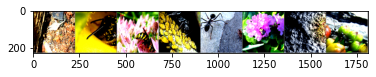

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# pytorch dataloader


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders_dict["train"])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
labels

tensor([0, 1, 1, 0, 0, 1, 0, 0])